In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_openml

def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
sort_by_target(mnist) # fetch_openml() returns an unsorted dataset

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
X, y = mnist['data'], mnist['target']
print("X shape: {} \t y shape: {}".format(X.shape, y.shape))

X shape: (70000, 784) 	 y shape: (70000,)


(-0.5, 27.5, 27.5, -0.5)

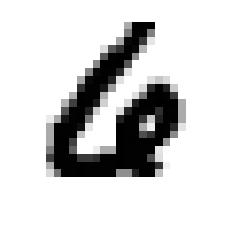

In [51]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[40000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, 
          interpolation='nearest')
plt.axis('off')

In [5]:
y[40000]

6

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training Binary Classifier

Classifier to detect if number is 6 or not i.e. number 6-detector

In [8]:
y_train_6 = (y_train == 6)
y_test_6 = (y_test == 6)

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_6)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
sgd_clf.predict([some_digit])

array([ True])

#### Performance Measures
##### Measuring accuracy using Cross-Validation

In [11]:
from sklearn.model_selection import StratifiedKFold # performs stratified sampling to produce folds
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_6):
    # Each iteration creates a clone of classifier
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_6[train_index])
    X_test_folds = X_train[test_index]
    y_test_folds = (y_train_6[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds) # Training each clone on training folds
    y_pred = clone_clf.predict(X_test_folds)    # Predictions for testing fold
    n_correct = sum(y_pred == y_test_folds)     # No of correct predictions
    print(n_correct / len(y_pred))              # Ratio of correct predictions

0.9416029198540073
0.9786
0.9808990449522477


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_6, cv=3, scoring='accuracy')

array([0.94160292, 0.9786    , 0.98089904])

We can observe accuracy of more than 97%

Classifier to classify every number which is in 'Not-6' class:

In [13]:
from sklearn.base import BaseEstimator

class Never6Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_6_clf = Never6Classifier()
cross_val_score(never_6_clf, X_train, y_train_6, cv=3, scoring='accuracy')

array([0.90235, 0.8994 , 0.90235])

We can notice how even a dumb class predicted with 90% accuracy. This is because only about 10% of the images are of 6, so if you always guess false, you will be right 90% of the time. This shows skewness of data ie some classes are more frequent than others

#### Confusion Matrix
The general idea is to count no. of times class A has been classified as class B

In [14]:
from sklearn.model_selection import cross_val_predict # similar to cross_val_scores but returns predictions instead of scores
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3)
confusion_matrix(y_train_6, y_train_pred)

array([[52621,  1461],
       [  517,  5401]], dtype=int64)

---
#### Note: 
[[r1c1, r1c2],
 [r2c1, r2c2]]
 
Here rows represent actual values ie 
- r1: non 6 images
- r2: 6 images
                                      
And columns represent predicted values ie 
- c1: non 6 images
- c2: 6 images

This means 
- r1c1 is no. of correct predictions for non 6 images
- r1c1 is no. of incorrect predictions for non 6 images
- r1c1 is no. of incorrect predictions for 6 images
- r1c1 is no. of correct predictions for 6 images

---

In [15]:
y_train_perfect_preds = y_train_6
confusion_matrix(y_train_6, y_train_perfect_preds)

array([[54082,     0],
       [    0,  5918]], dtype=int64)

---
#### Recall and Precision

In [16]:
from sklearn.metrics import precision_score, recall_score

print("Precision score: ", precision_score(y_train_6, y_train_pred)) 
print("Recall score: ", recall_score(y_train_6, y_train_pred))

Precision score:  0.7870883124453512
Recall score:  0.912639405204461


---
Precision score represents that prediction of image 6 is right for 89% of times ie if 100 images of various numbers are identified as 6 than only 89 of them are actually images of 6.

Recall score represents about 91% of images of 6 are identified correctly ie. out of 100 images of 6 only 91 are identified as 6 rest are not

---

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_6, y_train_pred) # f1 favours classifier with similar precision and recall score

0.845226917057903

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([112219.94512412])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_6, cv=3, method="decision_function")

from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_6, y_scores)

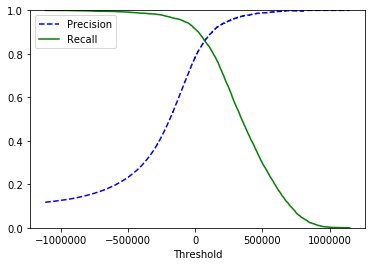

In [22]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#### ROC Curve
Plots true positive rate against false positive rate.

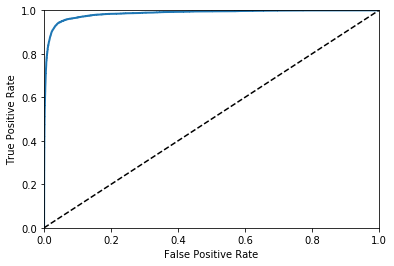

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_6, y_scores)

def plot_roc_curve(fpr=fpr, tpr=tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') # recall
    
plot_roc_curve()
plt.show()

---
Once again, higher the TPR, lesser th FPR. The dotted line represents ROC curve of a purely random classifier; a good classifier stays far from that dotted line

---

In [24]:
# Area Under the curve
# Perfect classifer has AUC = 1
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_6, y_scores)

0.9852320026619236

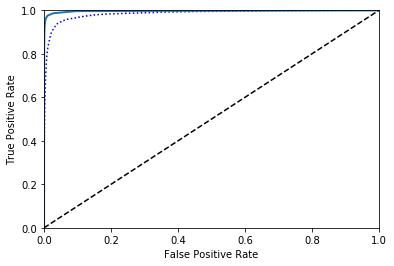

In [25]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_6, cv=3,
                                    method='predict_proba')

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_6, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")

*********** 
Note, how curve of Random Forest is farther away form the dotted line compared to SGD Curve

In [26]:
roc_auc_score(y_train_6, y_scores_forest)

0.9969783861436101

In [27]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_6, cv=3)

print("Precision score: ", precision_score(y_train_6, y_train_pred_forest)) 
print("Recall score: ", recall_score(y_train_6, y_train_pred_forest))

Precision score:  0.9870838639257777
Recall score:  0.9168638053396417


---
### Multiclass Classifier

In [28]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([6], dtype=int8)

In [29]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-785838.31350559, -950826.23380641, -294104.67810887,
        -508622.62958618, -383757.85647072, -786394.53897059,
         112219.94512412, -828487.12821712, -810998.74336819,
        -804952.08131232]])

In SGD Classifier, sklearn trains 10 different binary classifers. The class with highest decision score is selected. In this case 6 has highest score, so it is predicted class

In [30]:
np.argmax(some_digit_scores)

6

In [31]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

In [32]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([6], dtype=int8)

In [33]:
ovo_clf.estimators_

(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
        n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
        power_t=0.5, random_state=42, shuffle=True, tol=None,
        validation_fraction=0.1, verbose=0, warm_start=False),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
        n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
        power_t=0.5, random_state=42, shuffle=True, tol=None,
        validation_fraction=0.1, verbose=0, warm_start=False),
 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss

In [34]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([6], dtype=int8)

In [35]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. ]])

In [36]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.86552689, 0.87339367, 0.86507976])

In [37]:
# Standard Scaling input
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.91321736, 0.90904545, 0.90618593])

Notice how scalling the input can make a huge difference on accuracy.

#### Error Analysis

In [38]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5735,    4,   19,   10,   11,   48,   47,    9,   37,    3],
       [   1, 6464,   46,   24,    6,   40,    7,   16,  127,   11],
       [  57,   36, 5330,  105,   82,   26,   88,   58,  160,   16],
       [  54,   38,  142, 5317,    1,  250,   37,   61,  136,   95],
       [  18,   27,   35,    5, 5365,   11,   59,   34,   87,  201],
       [  68,   41,   34,  180,   76, 4631,  110,   32,  155,   94],
       [  28,   22,   43,    2,   42,   89, 5640,    6,   46,    0],
       [  22,   21,   66,   29,   52,   12,    7, 5834,   15,  207],
       [  52,  140,   73,  156,   16,  160,   53,   33, 5020,  148],
       [  42,   32,   25,   86,  168,   47,    3,  236,   77, 5233]],
      dtype=int64)

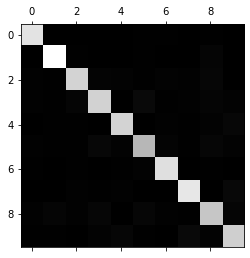

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

NOTE: Most of the light colored images are along the diagnol, which means that these numbers are being classified correctly. But the image of number 5 looks slightly darker than others. This could mean 
- either dataset has fewer images of 5, or
- the classifier doesn't perform well on 5 compared to others.

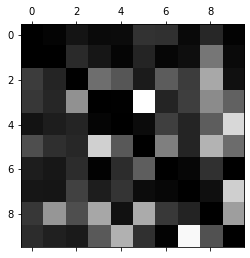

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# ploting errors
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

NOTE: 
- columns of 8 and 9 are much brighter. This shows how often 8 and 9 are being confused with other numbers
- in case 5 there is only particular boxes which are bright (ie 3). This shows how often 5 is being confused with 3.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

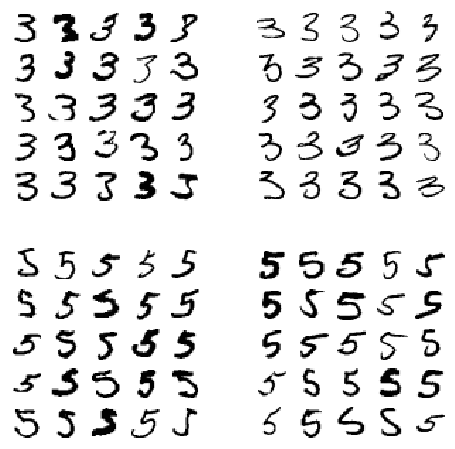

In [41]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

### Multilabel Classification

In [42]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

This shows that 6 is neither large nor odd

In [43]:
knn_clf.predict([some_digit])

array([[False, False]])

#### WARNING!!!
Following cell may take hours to execute

In [44]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3, n_jobs=2)

In [45]:
f1_score(y_train, y_train_knn_pred, average='weighted')

0.9684277468272913

In [48]:
f1_score(y_train, y_train_knn_pred, average='macro')

0.968302724741951

### Multioutput Classification

In [50]:
# Adding noise to images
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

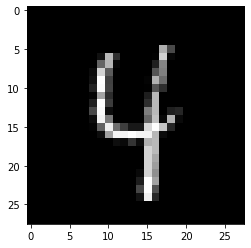

In [58]:
some_digit_test = X_train[5000]
some_digit_test_img = some_digit_test.reshape(28, 28)

plt.imshow(some_digit_test_img, cmap=plt.cm.gray, interpolation='nearest')

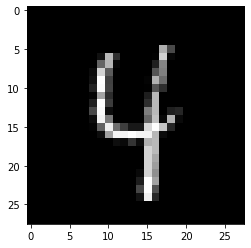

In [59]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([some_digit_test])
plt.imshow(some_digit_test_img, cmap=plt.cm.gray, interpolation='nearest')